The purpose of this notebook is to evaluate user query results from text+image embeddings and image only embeddings. The visualisation function accepts two dataframes of returned results sorted on similarity score in decreasing fashion.


In [ ]:
!pip install pinecone --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.8/419.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 3.3 MB/s eta 0:00:00


In [ ]:
pip install mplcursors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 65.5 MB/s eta 0:00:00
  Created wheel for mplcursors: filename=mplcursors-0.5.3-py3-none-any.whl size=20729 sha256=1a397b108168ef680876be4c6b3bd9ce30c54fc9f7fa1fc706b911edc8cfeff6
  Stored in directory: /root/.cache/pip/wheels/83/43/92/44f9515471f56877c774a515a2902d3e5484ea1bc7fd412d03
Successfully built mplcursors
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [ ]:
#Import Necessary Libraries

import numpy as np
import pandas as pd
import ast
import torch
from tqdm import tqdm
import pinecone
import multiprocessing as mp
from transformers import CLIPProcessor, CLIPModel, CLIPVisionModelWithProjection, CLIPTextModelWithProjection
from PIL import Image

In [ ]:
import os
from transformers import CLIPProcessor, CLIPModel, CLIPTextModel, CLIPTextModelWithProjection
import torch
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [ ]:
def get_embeddings(query):
    text_inputs = processor(text=query, return_tensors="pt", padding=True, truncation = True)
    text_inputs = {k: v.to(device) for k, v in text_inputs.items()}  # Move text inputs to GPU
    # print(text_inputs['input_ids'])
    with torch.no_grad():
        text_embeds = model.get_text_features(**text_inputs)
        # text_embeds = model(**text_inputs)
        # text_embeds = text_embeds.pooler_output
        # text_embeds = text_embeds.cpu()
        # text_embeds = model(**text_inputs).text_embeds
    return text_embeds

In [ ]:
from io import BytesIO
import requests
from PIL import Image
from IPython.display import display

'''def view_results(df):
  top_products = df
  for index, row in top_products.iterrows():
    print(f"Title: {row['title']}")
    print(f"Description: {row['description']}")
    print(f"Score: {row['score']}")

    try:
        # Fetch and display image
        response = requests.get(row['image_url'])
        img = Image.open(BytesIO(response.content))
        display(img)
    except Exception as e:
        print(f"Could not load image from URL: {row['image_url']}. Error: {e}")

    print("-" * 50)  # Separator between products '''


In [ ]:
import plotly.graph_objects as go
from PIL import Image
import requests
from io import BytesIO

def display_product_grid_plotly(df_add, image_size=(100, 220)):
    fig = go.Figure()

    # Loop through each product and add images in a single row
    for i in range(10):
        # Get the details for the image
        img_url_add = df_add.iloc[i]['image_url']
        title_add = df_add.iloc[i]['title']
        description_add = df_add.iloc[i]['description']

        # Fetch and process the image, resizing it to ensure uniformity
        img_data_add = Image.open(BytesIO(requests.get(img_url_add).content))
        img_data_add = img_data_add.resize(image_size)  # Resize to the specified image_size

        # Add scatter point with hover info
        fig.add_trace(go.Scatter(
            x=[i], y=[1],  # Position in the row
            mode="markers",
            marker=dict(
                size=100,
                opacity=0,
            ),
            hovertemplate=f"<b>{title_add}</b><br>{description_add}<extra></extra>"
        ))

        # Use add_layout_image for the resized background image
        fig.add_layout_image(
            dict(
                source=img_data_add,
                xref="x", yref="y",
                x=i, y=1,  # Position in the grid
                sizex=1, sizey=1,
                xanchor="center", yanchor="middle"
            )
        )

    # Add title above the row
    '''fig.add_annotation(
        x=0.5, y=1.5,  # Position slightly above the first row
        showarrow=False,
        font=dict(size=16, color="blue"),
        xref="x", yref="y"
    ) '''

    # Update layout for a clean grid appearance
    fig.update_layout(
        height=300,
        width=1400,
        margin=dict(l=20, r=20, t=40, b=20),
        xaxis=dict(showticklabels=False, showgrid=False, zeroline=False, range=[-0.5, 11.5]),
        yaxis=dict(showticklabels=False, showgrid=False, zeroline=False, range=[0.5, 1.5]),
        showlegend=False,
        hovermode="closest"
    )

    # Display the figure
    fig.show()


## User-query embedding

In [ ]:
user_query = "standing desk 55inches"
user_query_embedding = get_embeddings(user_query).detach().cpu()

#Convert the tensor to a numpy array
user_query_numpy = user_query_embedding.numpy()

# Convert the numpy array to a list
user_query_list = user_query_numpy.tolist()

## Text + Image - Mean

In [ ]:
'''#Get top 10 Vectors - Text + Image Embeddings Combined

#To get response based on User Query Vector

import pandas as pd
from google.colab import userdata
#pinecone_api = userdata.get('pinecone_key_sameer_koppolu')
pinecone_api = '13e8cec3-814f-4035-9f4b-861c983d837c'

pc = pinecone.Pinecone(api_key=pinecone_api)
index = pc.Index("health-household-mean",
                 host = "https://health-household-mean-yspnai5.svc.aped-4627-b74a.pinecone.io")


response = index.query(
    namespace="",
    vector= user_query_list[0],
    top_k = 10, #How many vectors to retrieve
    include_values = False,
    include_metadata=True,
    #filter={"genre": {"$eq": "action"}}
)


data = []
for match in response['matches']:
    data.append({
        'id': match['id'],
        'score': match['score'],
        **match.get('metadata', {})  # Add metadata if available
    })

response_df_mean = pd.DataFrame(data)
response_df_mean = response_df_mean.sort_values(by = 'score', ascending = False)
response_df_mean
'''

'#Get top 10 Vectors - Text + Image Embeddings Combined\n\n#To get response based on User Query Vector\n\nimport pandas as pd\nfrom google.colab import userdata\n#pinecone_api = userdata.get(\'pinecone_key_sameer_koppolu\')\npinecone_api = \'13e8cec3-814f-4035-9f4b-861c983d837c\'\n\npc = pinecone.Pinecone(api_key=pinecone_api)\nindex = pc.Index("health-household-mean",\n                 host = "https://health-household-mean-yspnai5.svc.aped-4627-b74a.pinecone.io")\n\n\nresponse = index.query(\n    namespace="",\n    vector= user_query_list[0],\n    top_k = 10, #How many vectors to retrieve\n    include_values = False,\n    include_metadata=True,\n    #filter={"genre": {"$eq": "action"}}\n)\n\n\ndata = []\nfor match in response[\'matches\']:\n    data.append({\n        \'id\': match[\'id\'],\n        \'score\': match[\'score\'],\n        **match.get(\'metadata\', {})  # Add metadata if available\n    })\n\nresponse_df_mean = pd.DataFrame(data)\nresponse_df_mean = response_df_mean.sort_v

## Text + Image - Add

In [ ]:
pinecone_api = '5494077b-a9de-4816-91fd-5257adbfbdce'

pc = pinecone.Pinecone(api_key=pinecone_api)
index = pc.Index("office-products-add",
                 host = "https://office-products-add-rw8lvgs.svc.aped-4627-b74a.pinecone.io")

response = index.query(
    namespace="",
    vector= user_query_list[0],
    top_k = 10, #How many vectors to retrieve
    include_values = False,
    include_metadata=True,
    #filter={"genre": {"$eq": "action"}}
)


data = []
for match in response['matches']:
    data.append({
        'id': match['id'],
        'score': match['score'],
        **match.get('metadata', {})  # Add metadata if available
    })

response_df_add = pd.DataFrame(data)
response_df_add = response_df_add.sort_values(by = 'score', ascending = False)
response_df_add

,id,score,description,image_url,parent_asin,text_image_cosine_similarity,title
0,B00BCNUA0E,0.687371,"72"" x 24"" Table DeskbyOffice Source Trusted: 2...",https://m.media-amazon.com/images/I/31D0ZdTIvY...,B00BCNUA0E,0.311579,"72"" x 24"" Table Desk"
1,B014LNRP1I,0.677137,Upright Desks are built in the U.S.A. with top...,https://m.media-amazon.com/images/I/41csIOHja6...,B014LNRP1I,0.359850,Adjustable Height Stand Up Desk (2ft x 2ft)
2,B00JPN83NE,0.675250,Make the most out of your desk space with the ...,https://m.media-amazon.com/images/I/51o5EOFFH2...,B00JPN83NE,0.303158,Good Use Microdesk (MD-SS)
3,B000CS1FU4,0.675250,Make the most out of your desk space with the ...,https://m.media-amazon.com/images/I/51o5EOFFH2...,B000CS1FU4,0.303158,Good Use Microdesk (MD-SS)
4,B0057DVZ22,0.667301,Includes 1 file cabinet with 1 drawer that ope...,https://m.media-amazon.com/images/I/41xiiLaK3W...,B0057DVZ22,0.327153,Office Desk & Cabinet Set
5,B01LYELYU0,0.666903,"The RiseUP Table Top is a portable, affordable...",https://m.media-amazon.com/images/I/41Tj274+pU...,B01LYELYU0,0.331224,Adjustable Standing Desk - RiseUP Table Top
6,B01MR2FADJ,0.652785,"Aeon 80010 Standing desk features:, Dual gas p...",https://m.media-amazon.com/images/I/51MuHqFLKl...,B01MR2FADJ,0.392892,Aeon Sit to Stand Desk - Height Adjustable (36...
7,B07FN8N5YF,0.648936,"Work as you wish: Sitting, standing, or anywhe...",https://m.media-amazon.com/images/I/51vAY8UtEc...,B07FN8N5YF,0.340925,"Ivation Standing Desk 31"" with Dual Surfaces S..."
8,B072MW8ZJS,0.645979,"Electric DeskRiser Standing Desk, The Electric...",https://m.media-amazon.com/images/I/41PnjiT1h9...,B072MW8ZJS,0.323924,Electric Standing Desk | Adjustable Height Sit...
9,B000WXY1FU,0.645112,Spacious work surface for multi usesDesk top c...,https://m.media-amazon.com/images/I/41Hmf3SvPg...,B000WXY1FU,0.340490,Orchard Hills Desk


## Only image embeddings

In [ ]:
pinecone_api = 'c4fd685b-80da-47cc-8f5a-30f6f85db734'

pc = pinecone.Pinecone(api_key=pinecone_api)
index = pc.Index("office-products-image",
                 host = "https://office-products-image-3xbp7xc.svc.aped-4627-b74a.pinecone.io")

response = index.query(
    namespace="",
    vector= user_query_list[0],
    top_k = 10, #How many vectors to retrieve
    include_values = False,
    include_metadata=True,
    #filter={"genre": {"$eq": "action"}}
)


data = []
for match in response['matches']:
    data.append({
        'id': match['id'],
        'score': match['score'],
        **match.get('metadata', {})  # Add metadata if available
    })

response_df_image = pd.DataFrame(data)
response_df_image = response_df_image.sort_values(by = 'score', ascending = False)
response_df_image

,id,score,description,image_url,parent_asin,text_image_cosine_similarity,title
0,B078M8TN5Y,0.341165,"🌸, FLEXIBLE COMPUTER DESK, 🌸 Computer desk sma...",https://m.media-amazon.com/images/I/41xYY1cZyX...,B078M8TN5Y,0.343691,Homgrace Computer Desk Z-Shaped PC Desk Movabl...
1,B014LNRP1I,0.340079,Upright Desks are built in the U.S.A. with top...,https://m.media-amazon.com/images/I/41csIOHja6...,B014LNRP1I,0.359850,Adjustable Height Stand Up Desk (2ft x 2ft)
2,B01NCYWKYM,0.339946,Tired of sitting all day but don't want to com...,https://m.media-amazon.com/images/I/41pEiR370h...,B01NCYWKYM,0.355208,FitDesk Sit-to-Stand Desk - 30.7 x 22.8 Inches...
3,B06Y36M9NM,0.339526,Product highlights no pre-determined heights--...,https://m.media-amazon.com/images/I/41tFRkGUUj...,B06Y36M9NM,0.402398,"FlexiSpot 27"" Height Adjustable Standing Desk ..."
4,B0B9NCDJY5,0.338776,Our products are designed and manufactured in ...,https://m.media-amazon.com/images/I/41zPNqZzmf...,B0B9NCDJY5,0.368654,Totnz Memory Electric Height Adjustable Desk S...
5,B0923R7Y3R,0.338672,It's difficult to focus on work if you keep ge...,https://m.media-amazon.com/images/I/41rbYrzeLa...,B0923R7Y3R,0.350220,"TRUVOY Electric Standing Desk 47""x24"" with Adj..."
6,B09DCYF7ND,0.337914,"Description, Lead a healthier and more product...",https://m.media-amazon.com/images/I/41rMa8tYRl...,B09DCYF7ND,0.361325,"Tangkula Electric Standing Desk, 48 x 24 Inch ..."
7,B0BG8SB3TY,0.337501,Our Professional home office furniture designe...,https://m.media-amazon.com/images/I/31-1r6AJhb...,B0BG8SB3TY,0.361666,FLEXISPOT Electric Stand Up Desk Standing Desk...
8,B07HCBLS4X,0.336613,"DEVAISE 43'' computer desk, with an attractive...",https://m.media-amazon.com/images/I/41sfAx0EIV...,B07HCBLS4X,0.357987,"DEVAISE 43"" Computer Desk with Cable Storage D..."
9,B08K2SPK78,0.335603,"SogesGame, The modern moblie stand up desk hom...",https://m.media-amazon.com/images/I/41EKECWY63...,B08K2SPK78,0.337315,SogesGame Mobile Laptop Stand 31.5 inches Smal...


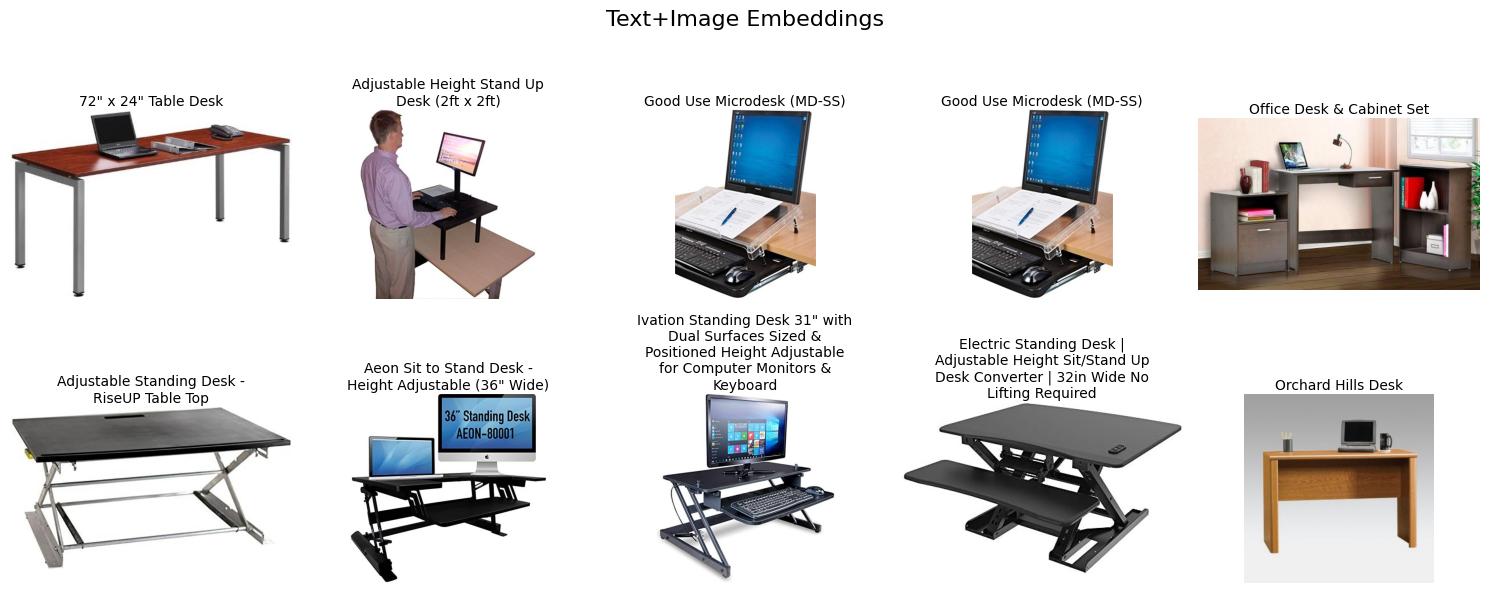

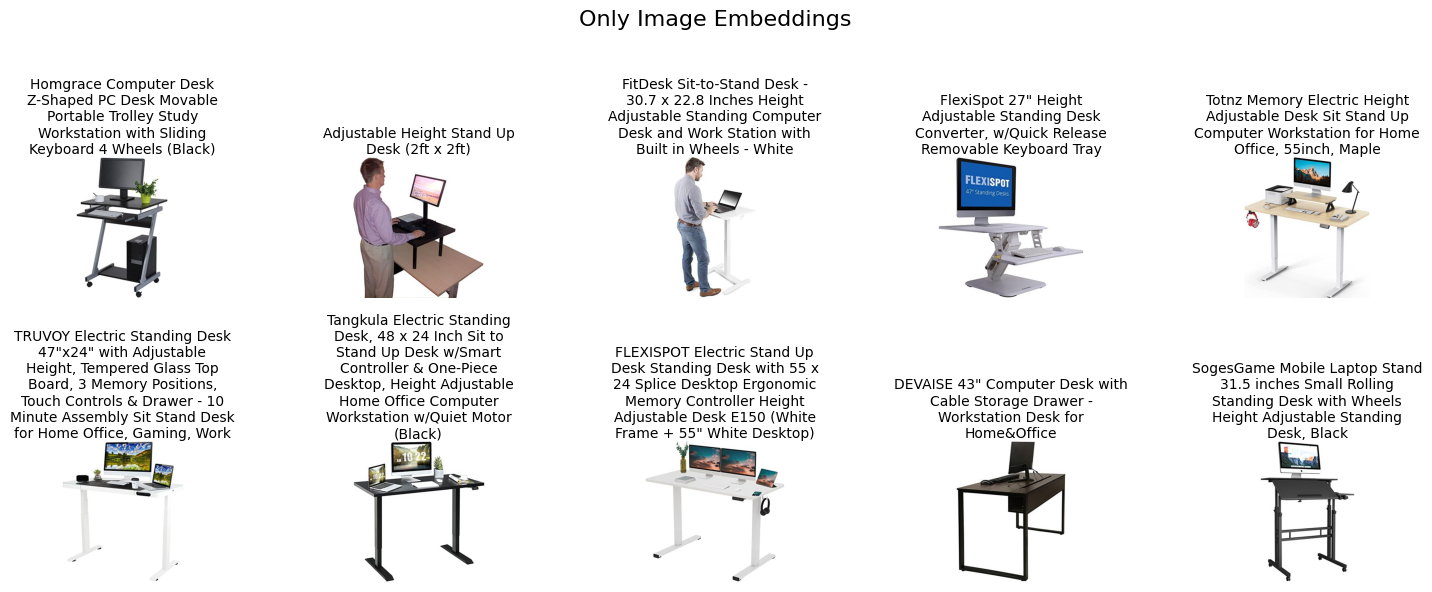

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import textwrap
import mplcursors

def plot_product_recommendations(df, title):
    """
    Plots product recommendations in a 2x5 grid from a DataFrame containing
    image URLs and product titles with hover functionality for descriptions.

    Parameters:
    df (pd.DataFrame): DataFrame with 'image_url', 'title', and 'description' columns.
    title (str): Main title for the plot.
    """
    # Check if DataFrame has the required columns
    if not all(col in df.columns for col in ['image_url', 'title', 'description']):
        raise ValueError("DataFrame must contain 'image_url', 'title', and 'description' columns.")

    # Create a 2x5 grid
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)

    # Loop through the grid and fill it with images and titles
    for ax, (index, row) in zip(axs.flatten(), df.iterrows()):
        # Fetch the image from the URL
        try:
            response = requests.get(row['image_url'])
            img = Image.open(BytesIO(response.content))
        except Exception as e:
            print(f"Error loading image at index {index}: {e}")
            img = np.random.rand(10, 10, 3)  # Use a random image if loading fails

        ax.imshow(img)

        # Wrap the title to avoid overlapping
        wrapped_title = textwrap.fill(row['title'], width=30)  # Adjust the width as needed
        ax.set_title(wrapped_title, fontsize=10, pad=3)  # Added pad for spacing
        ax.axis('off')  # Hide the axes

    # Adjust layout to prevent overlap
    plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Increase spacing between plots
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title

    # Create interactive cursor to display descriptions on hover
    cursor = mplcursors.cursor(axs.flatten(), hover=True)

    # Set hover behavior to show the product description
    @cursor.connect("add")
    def on_add(sel):
        sel.annotation.set_text(df['description'].iloc[sel.index])
        sel.annotation.get_bbox().set_facecolor('white')
        sel.annotation.get_bbox().set_alpha(0.8)

    plt.show()



# Call the function
plot_product_recommendations(response_df_add, 'Text+Image Embeddings')
plot_product_recommendations(response_df_image, 'Only Image Embeddings')

